In [1]:
import torch
from torchvision import models
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [2]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

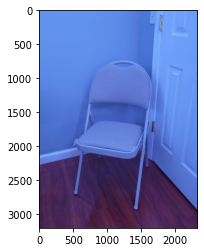

In [3]:
img = Image.open('../utils/images/schair_01.jpg').convert('RGB')
plt.imshow(img); plt.show()

In [16]:
trf = T.Compose([
                T.Resize(502),
                T.CenterCrop(500),
                T.ToTensor(),
                T.Normalize(mean = [0.485, 0.456, 0.406],
                           std = [0.229, 0.224, 0.225])])

In [17]:
inp = trf(img).unsqueeze(0)

In [18]:
out = dlab(inp)['out']
print(out.shape)

torch.Size([1, 21, 500, 500])


In [19]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print(om.shape)
print(np.unique(om))

(500, 500)
[0 9]


In [20]:
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
           # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
           (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
           # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
           (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
           # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
           (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
           # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
           (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
        
    rgb = np.stack([r, g, b], axis = 2)
    return rgb

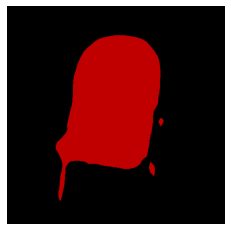

In [21]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.axis('off'); plt.show()

In [30]:
def separate_segmap(image, source, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
           # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
           (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
           # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
           (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
           # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
           (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
           # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
           (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
        
    rgb = np.stack([r, g, b], axis = 2)
    
    fgnd = cv.imread(source)
    
    fgnd = cv.cvtColor(fgnd, cv.COLOR_BGR2RGB)
    fgnd = cv.resize(fgnd, (r.shape[1], r.shape[0]))
    
    bgnd = 255 * np.ones_like(rgb).astype(np.uint8)
    
    fgnd = fgnd.astype(float)
    
    th, alpha = cv.threshold(np.array(rgb), 0, 255, cv.THRESH_BINARY)
    
    alpha = cv.GaussianBlur(alpha, (7, 7), 0)
    
    alpha = alpha.astype(float)/255
    
    fgnd = cv.multiply(alpha, fgnd)
    
    bgnd = cv.multiply(1.0 - alpha, bgnd)
    
    outImage = cv.add(fgnd, bgnd)
    
    return outImage/255

In [31]:
cutout = separate_segmap(om, '../utils/images/schair_01.jpg')
plt.imshow(cutout); plt.axis('off'); plt.show()

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:674: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'cv::arithm_op'
